In [ ]:
import numpy as np
import math
from dataclasses import dataclass

# ----------------- FCC lattice -----------------

@dataclass
class LatticeConfig:
    Lx: float = 2000.0
    Ly: float = 2000.0
    Lz: float = 2000.0
    sphere_radius: float = 15.0  # diameter 30

def fcc_unit_cell_spacing(R: float) -> float:
    # Touching spheres in FCC: a/√2 = 2R -> a = 2√2 R
    return 2.0 * math.sqrt(2.0) * R

def build_fcc_centers(cfg: LatticeConfig) -> np.ndarray:
    """Generate FCC sphere centers (no edge filtering yet)."""
    R = cfg.sphere_radius
    a = fcc_unit_cell_spacing(R)

    nx = int(math.ceil(cfg.Lx / a)) + 1
    ny = int(math.ceil(cfg.Ly / a)) + 1
    nz = int(math.ceil(cfg.Lz / a)) + 1

    bases = np.array([
        [0.0, 0.0, 0.0],
        [0.0, a/2, a/2],
        [a/2, 0.0, a/2],
        [a/2, a/2, 0.0],
    ], dtype=float)

    gx = np.arange(nx) * a
    gy = np.arange(ny) * a
    gz = np.arange(nz) * a

    pts = []
    for x in gx:
        for y in gy:
            for z in gz:
                origin = np.array([x, y, z], dtype=float)
                pts.append(bases + origin)
    centers = np.concatenate(pts, axis=0)

    # keep inside the box (geometric domain)
    m = (
        (centers[:,0] >= 0) & (centers[:,0] <= cfg.Lx) &
        (centers[:,1] >= 0) & (centers[:,1] <= cfg.Ly) &
        (centers[:,2] >= 0) & (centers[:,2] <= cfg.Lz)
    )
    return centers[m]

def keep_full_spheres_only(centers: np.ndarray, cfg: LatticeConfig) -> np.ndarray:
    """Filter centers so entire sphere fits in the box (avoid edge artifacts)."""
    R = cfg.sphere_radius
    mfull = (
        (centers[:,0] >= R) & (centers[:,0] <= cfg.Lx - R) &
        (centers[:,1] >= R) & (centers[:,1] <= cfg.Ly - R) &
        (centers[:,2] >= R) & (centers[:,2] <= cfg.Lz - R)
    )
    return centers[mfull]

# ----------------- Metric for a centered slab -----------------

def frac_full_over_intersected_centered(centers: np.ndarray,
                                        cfg: LatticeConfig,
                                        thicknesses: np.ndarray) -> np.ndarray:
    """Compute fraction(full/intersected) for a centered slab for all thicknesses."""
    zc = centers[:, 2].astype(float)
    R = cfg.sphere_radius
    frac = np.full_like(thicknesses, np.nan, dtype=float)

    for i, t in enumerate(thicknesses.astype(float)):
        z0 = 0.5 * (cfg.Lz - t)
        z1 = z0 + t
        inter = (zc + R > z0) & (zc - R < z1)
        full  = (zc >= z0 + R) & (zc <= z1 - R)
        ni = inter.sum()
        nf = full.sum()
        frac[i] = (nf / ni) if ni > 0 else np.nan
    return frac

# ----------------- Multi-run with small z-shifts -----------------

def multi_run_shifted(cfg: LatticeConfig,
                      thicknesses: np.ndarray,
                      K: int = 50,
                      seed: int = 0,
                      max_shift_fraction: float = 0.5):
    """
    Run K repeats. Each repeat applies a small z-shift to all centers, then filters
    to keep full spheres, then computes the centered-slab fraction curve.
    max_shift_fraction is expressed as a fraction of the FCC half-period (a/2).
    """
    rng = np.random.default_rng(seed)
    base = build_fcc_centers(cfg)

    a = fcc_unit_cell_spacing(cfg.sphere_radius)
    # FCC layers repeat every a/2 along z for our chosen basis
    z_period = a / 2.0
    max_shift = max_shift_fraction * z_period  # e.g., 0.5*(a/2) = a/4

    curves = []
    Ns = []
    for k in range(K):
        dz = rng.uniform(-max_shift, max_shift)
        shifted = base.copy()
        shifted[:, 2] = shifted[:, 2] + dz

        # clip away centers that leave the domain and then enforce full-sphere rule
        m_in = (shifted[:,2] >= 0) & (shifted[:,2] <= cfg.Lz)
        shifted = shifted[m_in]
        shifted = keep_full_spheres_only(shifted, cfg)

        Ns.append(shifted.shape[0])
        curves.append(frac_full_over_intersected_centered(shifted, cfg, thicknesses))

    curves = np.vstack(curves)  # shape (K, T)
    mean_frac = np.nanmean(curves, axis=0)
    std_frac  = np.nanstd(curves, axis=0, ddof=1) if K > 1 else np.zeros_like(mean_frac)

    return {
        "thickness": thicknesses,
        "mean_fraction": mean_frac,
        "std_fraction": std_frac,
        "all_curves": curves,
        "runs_cell_counts": np.array(Ns),
        "radius": cfg.sphere_radius,
        "Lz": cfg.Lz,
        "K": K,
        "z_period": z_period,
        "max_shift": max_shift,
    }

# ----------------- Example run & plot -----------------

if __name__ == "__main__":
    cfg = LatticeConfig(Lx=2000.0, Ly=2000.0, Lz=2000.0, sphere_radius=15.0)
    thicknesses = np.arange(2, 2051, 2, dtype=float)  # step 2 up to 2050

    res = multi_run_shifted(cfg, thicknesses, K=100, seed=42, max_shift_fraction=0.5)

    print(f"Runs: {res['K']}, FCC z half-period ≈ {res['z_period']:.3f}, max shift used ±{res['max_shift']:.3f}")
    print(f"Cells per run (after full-sphere filtering): min={res['runs_cell_counts'].min()}, "
          f"max={res['runs_cell_counts'].max()}, mean={res['runs_cell_counts'].mean():.1f}")

    # Plot mean ± SD; optional: overlay faint individual runs
    import matplotlib.pyplot as plt
    diameter = 2.0 * res["radius"]
    Lz = res["Lz"]

    plt.figure()
    # optional individual curves (comment out if too busy)
    # for curve in res["all_curves"]:
        # plt.plot(res["thickness"], curve, alpha=0.15, linewidth=1)

    plt.plot(res["thickness"], res["mean_fraction"], linewidth=2, label="Mean fraction (full / intersected)")
    # plt.fill_between(res["thickness"],
    #                  res["mean_fraction"] - res["std_fraction"],
    #                  res["mean_fraction"] + res["std_fraction"],
    #                  alpha=0.25, label="±1 SD")

    plt.axvline(diameter, linestyle="--", label=f"Cell diameter = {diameter:g}")
    plt.axvline(Lz, linestyle=":", label=f"Tissue thickness = {Lz:g}")
    plt.xlabel("Slab thickness")
    plt.ylabel("Fraction")
    plt.title("Fraction of fully captured among intersected (centered slab, z-shifted FCC, K runs)")
    plt.legend()
    plt.tight_layout()
    plt.show()


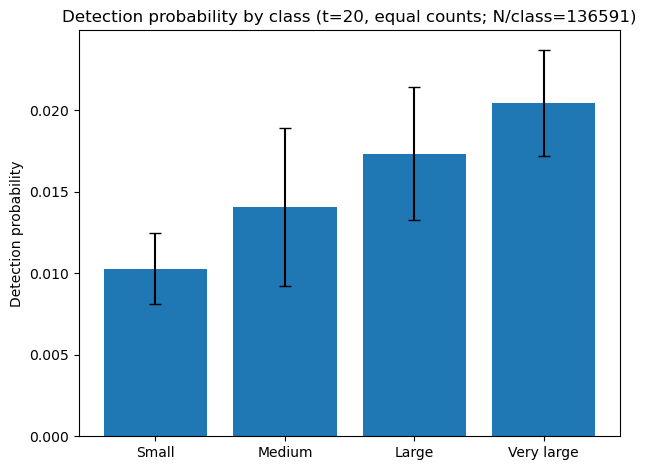

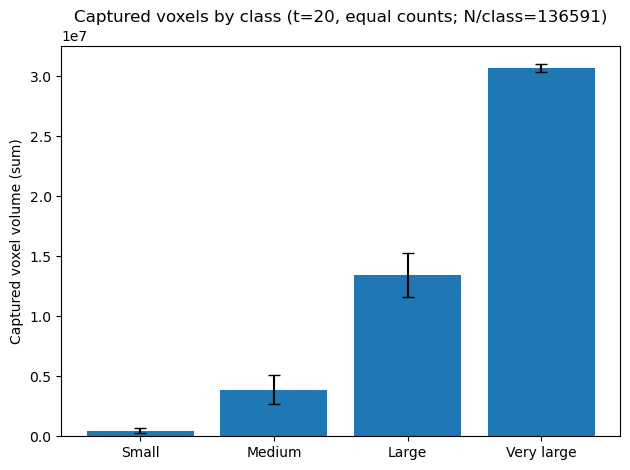

      Small | detect=0.010±0.002 | voxels=  481090.6±238341.8 | N/class=136591
     Medium | detect=0.014±0.005 | voxels= 3886463.9±1182326.6 | N/class=136591
      Large | detect=0.017±0.004 | voxels=13459794.2±1808591.6 | N/class=136591
 Very large | detect=0.020±0.003 | voxels=30697342.6±329585.0 | N/class=136591


In [ ]:
# Equal-count, constant-per-run multiclass FCC simulation (single thickness) with bar plots.
# Each class gets the SAME number of cells, and counts are constant across runs by
# selecting an "always-safe core" of lattice sites that stays inside the box under any 3D phase shift.
#
# Plots:
# 1) Detection probability per class (mean ± SD over runs)
# 2) Total captured voxel volume per class (mean ± SD over runs)
#
# Assumptions:
# - Lattice spacing set by the largest radius; large–large neighbors just touch when gap_kR=0.
# - Random 3D phase shifts are bounded; we choose sites safe for all such shifts.
#
# Note: matplotlib only, one chart per figure, and no explicit colors.

import numpy as np
import math
from dataclasses import dataclass
import matplotlib.pyplot as plt

# ----------------- Configuration dataclasses -----------------

@dataclass
class VolumeConfig:
    Lx: float = 2000.0
    Ly: float = 2000.0
    Lz: float = 2000.0

@dataclass
class ClassSpec:
    name: str
    radius: float  # sphere radius

@dataclass
class MultiClassMix:
    classes: list     # list[ClassSpec]
    gap_kR: float = 0.0  # extra surface gap in units of R_max between large-large neighbors (0=touching)

# ----------------- FCC lattice helpers -----------------

def fcc_lattice_constant_for_Rmax(Rmax: float, gap_kR: float = 0.0) -> float:
    """
    FCC nearest-neighbor distance d_nn = a/sqrt(2).
    Ensure max-radius spheres (Rmax) have center distance d_nn = 2*Rmax + gap, with gap = gap_kR * Rmax.
    => a = sqrt(2) * (2 + gap_kR) * Rmax
    """
    return math.sqrt(2.0) * (2.0 + gap_kR) * Rmax

def build_fcc_sites(vol: VolumeConfig, a: float) -> np.ndarray:
    """Generate FCC lattice sites inside [0,Lx]x[0,Ly]x[0,Lz]."""
    nx = int(math.ceil(vol.Lx / a)) + 1
    ny = int(math.ceil(vol.Ly / a)) + 1
    nz = int(math.ceil(vol.Lz / a)) + 1

    bases = np.array([
        [0.0, 0.0, 0.0],
        [0.0, a/2, a/2],
        [a/2, 0.0, a/2],
        [a/2, a/2, 0.0],
    ], dtype=float)

    gx = np.arange(nx) * a
    gy = np.arange(ny) * a
    gz = np.arange(nz) * a

    pts = []
    for x in gx:
        for y in gy:
            for z in gz:
                pts.append(bases + np.array([x, y, z], dtype=float))
    centers = np.concatenate(pts, axis=0)

    m = (
        (centers[:,0] >= 0) & (centers[:,0] <= vol.Lx) &
        (centers[:,1] >= 0) & (centers[:,1] <= vol.Ly) &
        (centers[:,2] >= 0) & (centers[:,2] <= vol.Lz)
    )
    return centers[m]

# ----------------- Sphere-slab intersection -----------------

def sphere_slab_intersection_volume(zc: np.ndarray, R: np.ndarray, z0: float, t: float) -> np.ndarray:
    """
    Vectorized sphere–slab intersection volume for varying radii.
    V = ∫ π(R^2 - (z - zc)^2) dz over overlap [l,u]; 0 if no overlap.
    """
    l = np.maximum(z0, zc - R)
    u = np.minimum(z0 + t, zc + R)
    valid = u > l
    vol = np.zeros_like(R, dtype=float)
    if np.any(valid):
        vol[valid] = math.pi * (R[valid]**2 * (u[valid] - l[valid]) -
                                ((u[valid] - zc[valid])**3 - (l[valid] - zc[valid])**3) / 3.0)
    return vol

# ----------------- Core selection with equal class counts -----------------

def select_equal_counts_core(vol: VolumeConfig,
                             mix: MultiClassMix,
                             max_shift_frac_xy: float,
                             max_shift_frac_z: float):
    """
    Build FCC sites with spacing set by Rmax. Compute an 'always safe' core for the largest radius
    under any phase shift within the specified bounds. Randomly partition that core into equal
    disjoint sets for each class. Returns centers (per-class), radii (per-class), and class labels.
    """
    # Lattice from largest radius
    Rmax = max(c.radius for c in mix.classes)
    a = fcc_lattice_constant_for_Rmax(Rmax, gap_kR=mix.gap_kR)
    sites = build_fcc_sites(vol, a)

    # Max absolute shifts we will apply
    max_dx = max_shift_frac_xy * a
    max_dy = max_shift_frac_xy * a
    max_dz = max_shift_frac_z  * (a/2.0)  # FCC layering period along z is a/2

    # 'Always-safe' core for the largest radius
    safe = (
        (sites[:,0] >= Rmax + max_dx) & (sites[:,0] <= vol.Lx - (Rmax + max_dx)) &
        (sites[:,1] >= Rmax + max_dy) & (sites[:,1] <= vol.Ly - (Rmax + max_dy)) &
        (sites[:,2] >= Rmax + max_dz) & (sites[:,2] <= vol.Lz - (Rmax + max_dz))
    )
    safe_idx = np.where(safe)[0]
    if safe_idx.size == 0:
        raise RuntimeError("No safe lattice sites found; reduce shift bounds or increase volume.")

    # Equal counts per class from the safe core
    n_classes = len(mix.classes)
    np.random.default_rng(123).shuffle(safe_idx)
    N_per = safe_idx.size // n_classes
    if N_per == 0:
        raise RuntimeError("Not enough safe sites to allocate at least one per class.")

    # Partition into disjoint chunks
    chunks = [safe_idx[i*N_per:(i+1)*N_per] for i in range(n_classes)]

    # Build per-class arrays
    centers_list = []
    radii_list = []
    labels_list = []
    for ci, cls in enumerate(mix.classes):
        idx = chunks[ci]
        centers_list.append(sites[idx])
        radii_list.append(np.full(idx.size, cls.radius, dtype=float))
        labels_list.append(np.full(idx.size, ci, dtype=int))

    centers = np.vstack(centers_list)
    radii   = np.concatenate(radii_list)
    labels  = np.concatenate(labels_list)

    # Return also the lattice constant and max shifts for later use
    return centers, radii, labels, a, (max_dx, max_dy, max_dz), N_per

# ----------------- Simulation for one thickness with constant equal counts -----------------

def simulate_equal_counts_single_thickness(vol: VolumeConfig,
                                           mix: MultiClassMix,
                                           t_slab: float,
                                           K: int = 200,
                                           seed: int = 0,
                                           max_shift_frac_xy: float = 0.5,
                                           max_shift_frac_z: float = 0.5):
    """
    Evaluate one centered slab thickness across multiple size classes.
    Uses an 'always-safe core' to keep counts constant and equal across classes and runs.
    Returns mean ± SD of detection probability and voxel totals per class over K 3D phase shifts.
    """
    rng = np.random.default_rng(seed)

    centers_base, radii_base, labels_base, a, (max_dx, max_dy, max_dz), N_per = select_equal_counts_core(
        vol, mix, max_shift_frac_xy, max_shift_frac_z
    )

    # Slab bounds (centered)
    z0 = 0.5 * (vol.Lz - t_slab)
    z1 = z0 + t_slab

    n_classes = len(mix.classes)
    det_runs = [[] for _ in range(n_classes)]
    vox_runs = [[] for _ in range(n_classes)]

    # K random 3D shifts within the bounds used to define the safe core
    for _ in range(K):
        dx = rng.uniform(-max_dx, +max_dx)
        dy = rng.uniform(-max_dy, +max_dy)
        dz = rng.uniform(-max_dz, +max_dz)

        centers = centers_base + np.array([dx, dy, dz], dtype=float)
        radii   = radii_base
        labels  = labels_base

        # Intersections (any overlap with slab)
        zc = centers[:,2]
        inter = (zc + radii > z0) & (zc - radii < z1)

        # Volumes only for intersected
        vols = np.zeros_like(radii)
        if np.any(inter):
            vols[inter] = sphere_slab_intersection_volume(zc[inter], radii[inter], z0, t_slab)

        for j in range(n_classes):
            m_class = (labels == j)
            n_class = int(m_class.sum())  # constant and equal (=N_per)
            n_inter = int((inter & m_class).sum())
            det_runs[j].append(n_inter / n_class if n_class > 0 else np.nan)
            vox_runs[j].append(float(vols[m_class].sum()))

    class_names = [c.name for c in mix.classes]
    det_mean = np.array([np.nanmean(det_runs[j]) for j in range(n_classes)], dtype=float)
    det_sd   = np.array([np.nanstd(det_runs[j], ddof=1) for j in range(n_classes)], dtype=float)
    vox_mean = np.array([np.mean(vox_runs[j]) for j in range(n_classes)], dtype=float)
    vox_sd   = np.array([np.std(vox_runs[j], ddof=1) for j in range(n_classes)], dtype=float)

    return {
        "class_names": class_names,
        "det_mean": det_mean,
        "det_sd": det_sd,
        "vox_mean": vox_mean,
        "vox_sd": vox_sd,
        "t_slab": t_slab,
        "K": K,
        "N_per_class": N_per,
        "a": a
    }

# ----------------- Example usage & bar plots -----------------

if __name__ == "__main__":
    vol = VolumeConfig(2000.0, 2000.0, 2000.0)

    # Define four classes with equal counts: Small, Medium, Large, Very Large
    classes = [
        ClassSpec("Small", 5.0),        # D=10
        ClassSpec("Medium", 10.0),      # D=20
        ClassSpec("Large", 15.0),       # D=30
        ClassSpec("Very large", 20.0),  # D=40
    ]
    mix = MultiClassMix(classes=classes, gap_kR=0.0)  # increase gap_kR to make the lattice globally sparser

    # Single slab thickness
    t_slab = 20.0

    res = simulate_equal_counts_single_thickness(
        vol, mix, t_slab,
        K=1000, seed=123,
        max_shift_frac_xy=0.5, max_shift_frac_z=0.5
    )

    # --- Bar plot 1: Detection probability per class (mean ± SD) ---
    x = np.arange(len(res["class_names"]))
    plt.figure()
    plt.bar(x, res["det_mean"], yerr=res["det_sd"], capsize=4)
    plt.xticks(x, res["class_names"], rotation=0)
    plt.ylabel("Detection probability")
    plt.title(f"Detection probability by class (t={res['t_slab']:.0f}, equal counts; N/class={res['N_per_class']})")
    plt.tight_layout()
    plt.show()

    # --- Bar plot 2: Total captured voxel volume per class (mean ± SD) ---
    plt.figure()
    plt.bar(x, res["vox_mean"], yerr=res["vox_sd"], capsize=4)
    plt.xticks(x, res["class_names"], rotation=0)
    plt.ylabel("Captured voxel volume (sum)")
    plt.title(f"Captured voxels by class (t={res['t_slab']:.0f}, equal counts; N/class={res['N_per_class']})")
    plt.tight_layout()
    plt.show()

    # Quick textual summary
    for name, dm, ds, vm, vs in zip(res["class_names"], res["det_mean"], res["det_sd"], res["vox_mean"], res["vox_sd"]):
        print(f"{name:>11s} | detect={dm:5.3f}±{ds:5.3f} | voxels={vm:10.1f}±{vs:8.1f} | N/class={res['N_per_class']}")
